# Exploratory Data Analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

### Import Data Set

In [2]:
df = pd.read_csv('../data/clean/tanzania.csv', index_col=0)

In [3]:
df.head()

,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,district_code,population,...,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,target
0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,5,109,...,False,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe,0
1,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,2,280,...,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,0
2,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,4,250,...,True,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,0
3,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,63,58,...,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,2
10,Private,62,Private,39.209518,-7.034139,Wami / Ruvu,Mizugo,Pwani,43,345,...,False,2011,submersible,private operator,never pay,salty,enough,machine dbh,other,0


In [5]:
df.sample(1)

,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,district_code,population,...,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,target
57386,Idc,1721,DWE,35.738684,-7.958621,Rufiji,Godauni A,Iringa,1,213,...,True,2009,gravity,vwc,never pay,soft,enough,spring,communal standpipe,0


### All of these are geographic locations
Do we need them all? Vidya says no!

In [6]:
df.iloc[:5, 9:16]

,population,scheme_management,permit,construction_year,extraction_type,management,payment_type
0,109,VWC,False,1999,gravity,vwc,annually
1,280,Other,True,2010,gravity,wug,never pay
2,250,VWC,True,2009,gravity,vwc,per bucket
3,58,VWC,True,1986,submersible,vwc,never pay
10,345,Private operator,False,2011,submersible,private operator,never pay
...,...,...,...,...,...,...,...
59391,210,Water authority,True,1967,gravity,vwc,never pay
59394,89,VWC,True,2007,submersible,vwc,monthly
59395,125,Water Board,True,1999,gravity,water board,per bucket
59396,56,VWC,True,1996,gravity,vwc,annually


Drop region_code because its the same as region.

## Feature Engineering

### Construction Year

In [7]:
# age = current_date - construction_year

How to deal with all the 20,709 missing values?

In [8]:
# check stats
print(df[df['construction_year'] != 0]['construction_year'].agg(['mean', 'median']))
df['construction_year'].value_counts().head(5)

mean      1996.91607
median    2000.00000
Name: construction_year, dtype: float64


2008    2361
2010    2243
2009    2223
2007    1411
2006    1293
Name: construction_year, dtype: int64

In [9]:
# How many 'zero' entries
(df['construction_year'] == 0).sum()

0

In [10]:
# if we cut out all the zeros, what does our target look like
df[(df['construction_year'] > 0)]['target'].value_counts()

0    18618
2    12450
1     2317
Name: target, dtype: int64

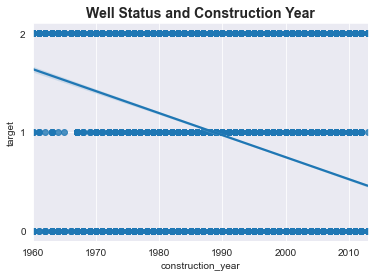

In [11]:
# definitely a strong relationship
fig, ax = plt.subplots(1)
sns.regplot(x='construction_year', y='target', data=df[(df['construction_year'] > 0)], ax=ax)
ax.set_yticks([0, 1, 2])
plt.title('Well Status and Construction Year', fontsize=14, fontweight='bold');

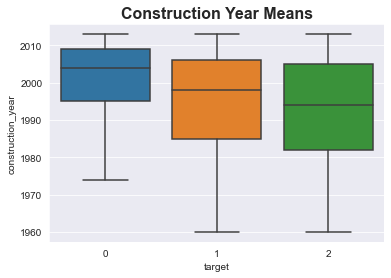

In [12]:
sns.boxplot(x='target',y='construction_year', data=df[df['construction_year'] > 0], showfliers=False)
plt.title('Construction Year Means', fontsize=16, fontweight='bold');

## Visualize Map

In [13]:
import contextily as ctx
import geopandas

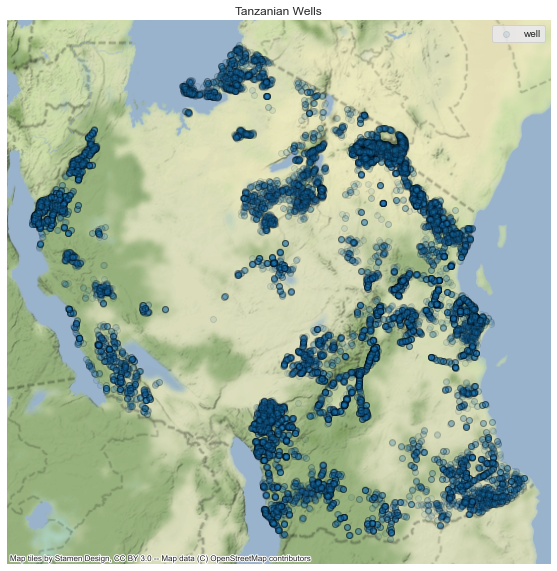

In [14]:
# create geopandas frames
gdf = geopandas.GeoDataFrame(
    df.copy(), geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

gdf = gdf.to_crs(epsg=3857)

# map the features using their geo coordinates
all_wells = gdf.plot(figsize=(10, 10), alpha=0.1, edgecolor='k', label='well')
plt.title('Tanzanian Wells')
plt.legend()
ctx.add_basemap(all_wells, source=ctx.providers.Stamen.TerrainBackground)
all_wells.set_axis_off()

WOW outliers. Some of the columns have missing coordinates.

In [15]:
gdf = gdf[gdf['longitude'] != 0]

### Wells by Status

In [16]:
gdf['target'].value_counts()

0    18618
2    12450
1     2317
Name: target, dtype: int64

In [17]:
functional_gdf = gdf[gdf['target'] == 0]
non_functional_gdf = gdf[gdf['target'] == 2]
needs_repair_gdf = gdf[gdf['target'] == 1]

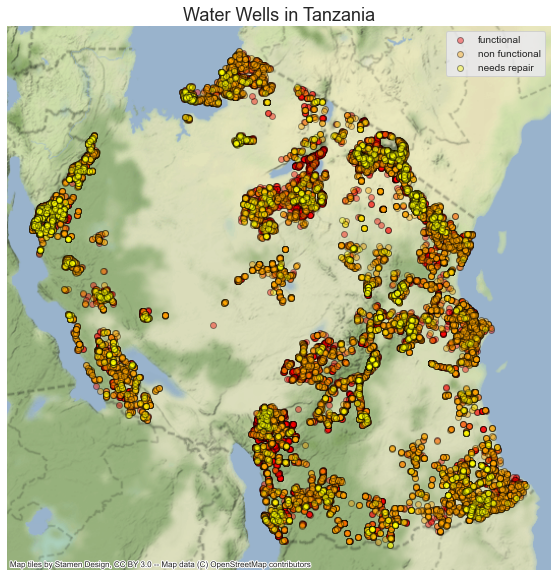

In [18]:
# map the features using their geo coordinates
wells_ax = functional_gdf.plot(figsize=(10, 10), alpha=0.4, edgecolor='k', label='functional', color='red')
wells_ax = non_functional_gdf.plot(ax=wells_ax, figsize=(10, 10), alpha=0.4, edgecolor='k', label='non functional', color='orange')
wells_ax = needs_repair_gdf.plot(ax=wells_ax, figsize=(10, 10), alpha=0.4, edgecolor='k', label='needs repair', color='yellow')

plt.legend()
plt.title('Water Wells in Tanzania', fontsize=18)
ctx.add_basemap(wells_ax, source=ctx.providers.Stamen.TerrainBackground)
wells_ax.set_axis_off()

### Wells by Year

In [19]:
construction_year_gdf = gdf[gdf['construction_year'] > 1900]

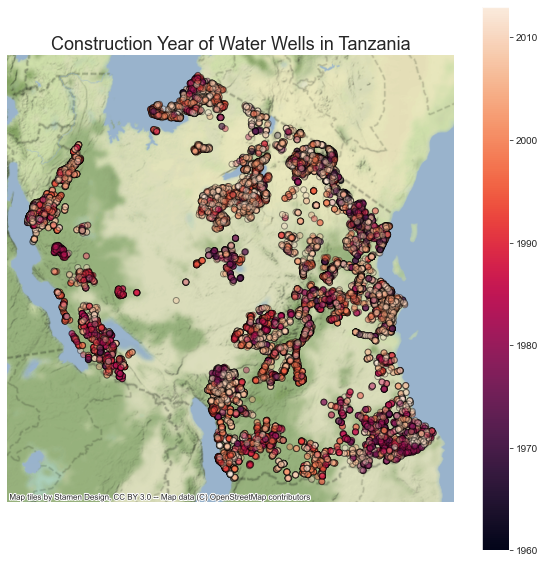

In [20]:
# map the features using their geo coordinates
wells_ax = construction_year_gdf.plot(column='construction_year', figsize=(10, 10), alpha=0.4, edgecolor='k', legend=True)
plt.title('Construction Year of Water Wells in Tanzania', fontsize=18)
ctx.add_basemap(wells_ax, source=ctx.providers.Stamen.TerrainBackground)
wells_ax.set_axis_off()

## Pandas Profile

In [28]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", html= {'style': { 'full_width': True } });

In [29]:
profile

### Interpolating gps_height from lat and long

In [24]:
df.sort_values(['latitude', 'longitude'])[['gps_height', 'latitude', 'longitude']].head(3)

,gps_height,latitude,longitude
43832,330,-11.649440,37.351138
57743,327,-11.648378,37.351869
7328,439,-11.586297,37.082702


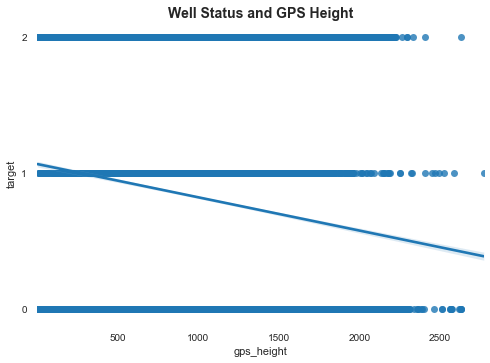

In [25]:
# definitely a strong relationship
fig, ax = plt.subplots(1)
sns.regplot(x='gps_height', y='target', data=df[(df['gps_height'] != 0)], ax=ax)
ax.set_yticks([0, 1, 2])
plt.title('Well Status and GPS Height', fontsize=14, fontweight='bold');